In [1]:
import tensorflow as tf

In [2]:
print(tf. __version__)

2.9.1


In [3]:
from tensorflow.keras import models,layers

In [235]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sb

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [6]:
#Loading data into tf.data.dataset

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",
                                                             shuffle = True,
                                                             image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                             batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 1 2 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 2 0 1 1 0 2 1 1]


In [11]:
for image_batch,label_batch in dataset.take(1):
    print(len(image_batch[0].numpy()))

256


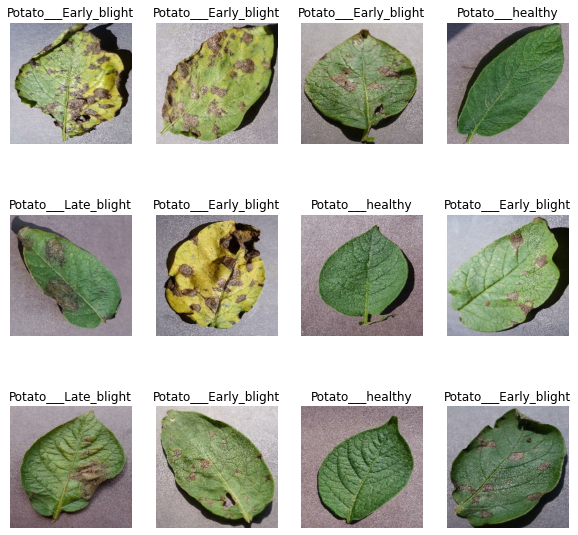

In [12]:
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [13]:
# 80% for training
# 20% ==> 10% validation, 10% testing
# At every end of epoch, validation is done

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val = 0.1
len(dataset)*val


6.800000000000001

In [18]:
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)

In [19]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1,test_split = 0.1,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)    
    return train_ds,val_ds,test_ds

In [20]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
#scaling the dataset
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [27]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [29]:
#Total params: 183,747 this is the number of weights we have to calculate

In [30]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics = ['accuracy'])

In [31]:
history = model.fit(train_ds,
         epochs = EPOCHS,
         batch_size=BATCH_SIZE,
         verbose=1,
         validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 153s 3s/step - loss: 0.8871 - accuracy: 0.5058 - val_loss: 0.7759 - val_accuracy: 0.5677
Epoch 2/50
54/54 [==============================] - 133s 2s/step - loss: 0.6235 - accuracy: 0.7199 - val_loss: 0.4408 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 131s 2s/step - loss: 0.4467 - accuracy: 0.7934 - val_loss: 0.4502 - val_accuracy: 0.7969
Epoch 4/50
54/54 [==============================] - 133s 2s/step - loss: 0.3156 - accuracy: 0.8692 - val_loss: 0.2091 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 140s 3s/step - loss: 0.2581 - accuracy: 0.8987 - val_loss: 0.1853 - val_accuracy: 0.9479
Epoch 6/50
54/54 [==============================] - 142s 3s/step - loss: 0.2297 - accuracy: 0.9167 - val_loss: 0.1548 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 135s 2s/step - loss: 0.2135 - accuracy: 0.9167 - val_loss: 0.2255 - val_accuracy: 0.9062
Epoch 8/50
54

In [54]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 832ms/step - loss: 0.0132 - accuracy: 0.9922


In [55]:
scores

[0.013163669966161251, 0.9921875]

In [56]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [57]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
len(history.history['accuracy'])

50

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

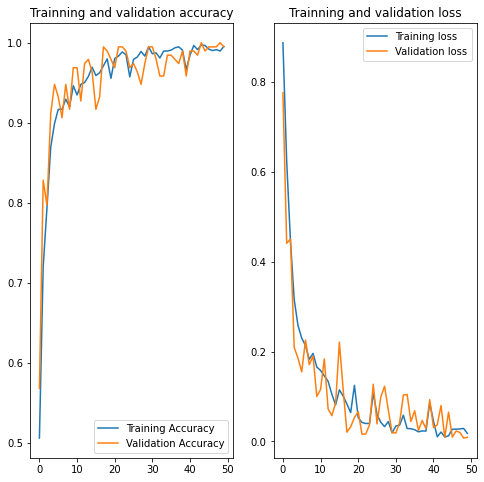

In [60]:
#plotting accuracy vs val accuracy
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label= "Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Trainning and validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = "Training loss")
plt.plot(range(EPOCHS),val_loss,label = "Validation loss")
plt.legend(loc = "upper right")
plt.title("Trainning and validation loss")
plt.show()

In [61]:
import numpy as np

First image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 368ms/step
Potato___Early_blight


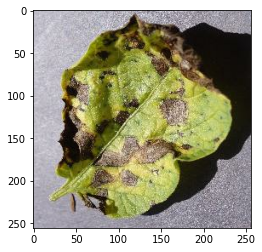

In [62]:
for images_batch,labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [181]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = np.argmax(predictions[0])
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 106ms/step


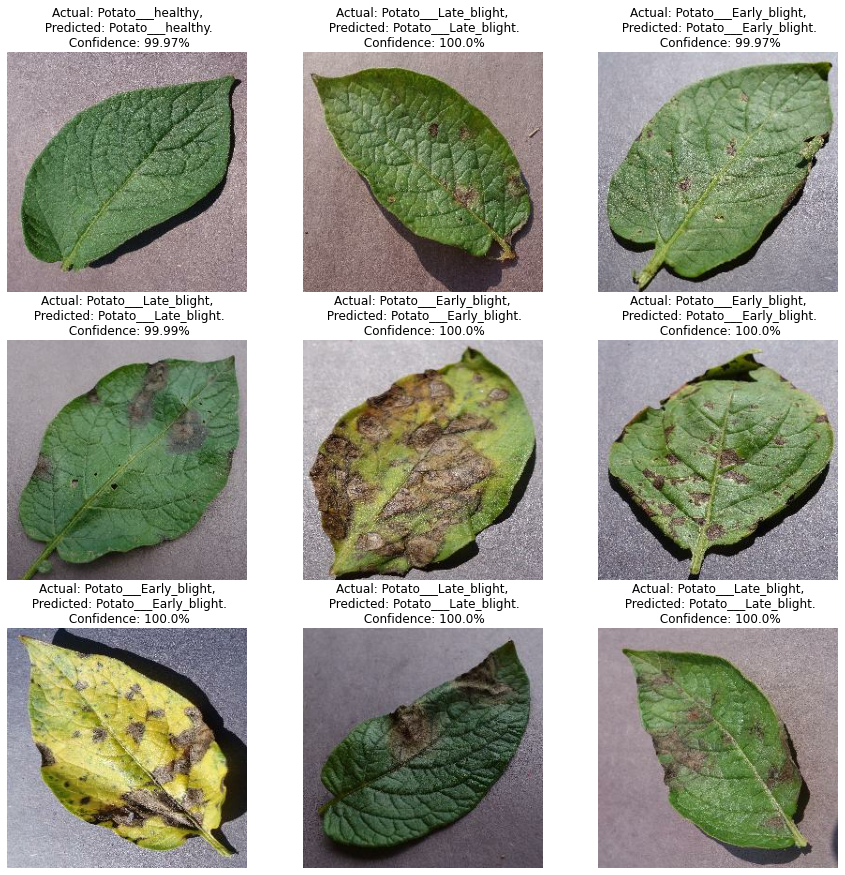

In [242]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {class_names[predicted]}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [66]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [67]:
model_loaded = tf.keras.models.load_model('../models/1')


In [90]:
model_loaded.evaluate(test_ds)


8/8 [==============================] - 2s 283ms/step - loss: 0.0132 - accuracy: 0.9922


[0.013163669966161251, 0.9921875]

1/1 [==============================] - 0s 32ms/step


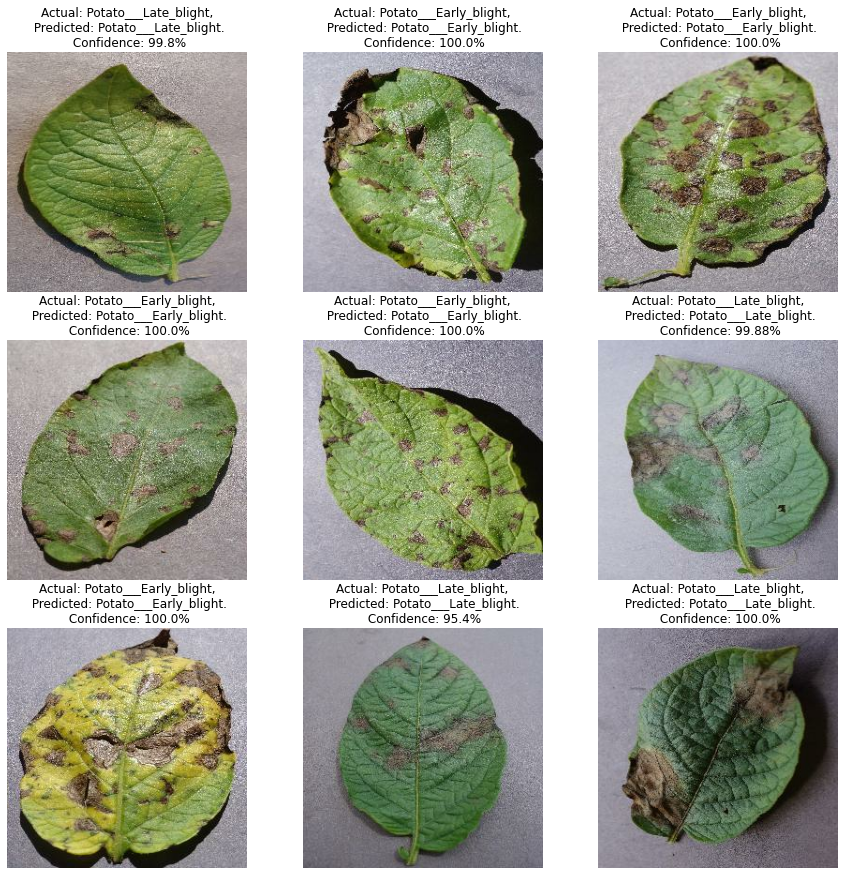

In [80]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_loaded,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [124]:
# =========================--------------------------END----------------------------------=========================

In [183]:
predicted_values = []
truth_values = []
for images,label in test_ds:
    for i in range(32):
        pred, conf = predict(model_loaded,images[i].numpy())
        predicted_values.append(pred)
        truth_values.append(label[i].numpy())

1/1 [==============================] - 0s 110ms/step


In [185]:
cm = confusion_matrix(truth_values,predicted_values)

In [207]:
font = {'family': 'serif',
        'color':  'green',
        'weight': 'normal',
        'size': 16,
        }

Text(0.5, 1.0, 'Confusion Matrix')

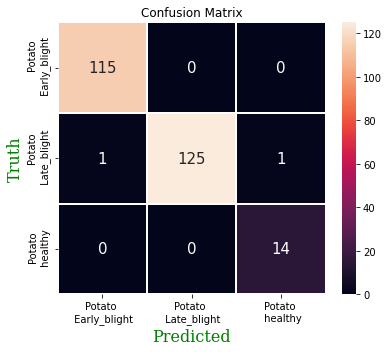

In [236]:
class_names_sb = ["Potato \n Early_blight", 'Potato \n Late_blight', 'Potato \n healthy']
plt.figure(figsize=(6,5))
sb.heatmap(cm,annot=True,fmt="d",linecolor="white",linewidths=2,xticklabels=class_names_sb,yticklabels = class_names_sb,annot_kws={'size': 15})
plt.xlabel("Predicted",fontdict=font)
plt.ylabel("Truth",fontdict=font)
plt.title("Confusion Matrix")